# Roberta test

In [19]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch
import transformers
# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [21]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x1 = self.d1(x)
        x2 = self.l1(x1)
        x3 = self.bn1(x2)
        x4 = torch.nn.Tanh()(x3)
        x5 = self.d2(x4)
        x6 = self.l2(x5)
        
        return x6

In [22]:
def dataset_embedding(MAX_SEQ_LEN, batch_size, text_col, label_col, test_doc):
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
    label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
    text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                       fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
    fields = [(text_col, text_field),(label_col, label_field)]

    # TabularDataset
    train, valid, test = TabularDataset.splits(path=source_folder, train=test_doc, validation=test_doc,
                                               test=test_doc, format='CSV', fields=fields, skip_header=True)
    
    test_iter = Iterator(test, batch_size=batch_size, device=device, train=False, shuffle=False, sort=False)
    return test_iter, tokenizer

In [23]:
import pandas as pd
sample = pd.read_csv('Data/test5.csv',sep = ',')

In [24]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  2319 non-null   object
 1   attack   2319 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.4+ KB


In [25]:
source_folder = 'Data'

In [26]:
max_seq_len = 128
batch_size = 16
text_col = 'comment'
label_col = 'attack'
test_doc = 'test5.csv'
sample2400_embed, tokenizer = dataset_embedding(max_seq_len, batch_size, text_col, label_col, test_doc)

In [27]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x1 = self.d1(x)
        x2 = self.l1(x1)
        x3 = self.bn1(x2)
        x4 = torch.nn.Tanh()(x3)
        x5 = self.d2(x4)
        x6 = self.l2(x5)
        
        return x6

In [28]:
from tqdm import tqdm
def generate(model, test_loader):
    y_pred = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (source, target), _ in tqdm(test_loader):
                mask = (source != PAD_INDEX).type(torch.uint8)
                output = model(source, attention_mask=mask)
                y_prob.extend(output.tolist())
    return y_prob

## Test on TOX

In [29]:
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']

In [30]:
output_path = 'Model_roberta_TOX'
model = ROBERTAClassifier()
model = model.to(device)
load_checkpoint(output_path + '/model.pkl', model)

0.08750647318014222

In [31]:
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
final_ro_tox_score = generate(model, sample2400_embed)

100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:12<00:00, 11.34it/s]


In [39]:
with open('Final result/TOX_roberta_2400.txt', 'w') as f:
    for item in final_ro_tox_score:
        f.write("%s\n" % item)

## Test on AC

In [32]:
output_path = 'Model_roberta_AC'
model = ROBERTAClassifier()
model = model.to(device)
load_checkpoint(output_path + '/model.pkl', model)

0.4722664388101225

In [33]:
final_ro_AC_score = generate(model, sample2400_embed)

100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:12<00:00, 11.51it/s]


In [40]:
with open('Final result/AC_roberta_2400.txt', 'w') as f:
    for item in final_ro_AC_score:
        f.write("%s\n" % item)

## Test on EA

In [34]:
output_path = 'Model_roberta_EA'
model = ROBERTAClassifier()
model = model.to(device)
load_checkpoint(output_path + '/model.pkl', model)

0.30514883347600696

In [35]:
final_ro_EA_score = generate(model, sample2400_embed)

100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:12<00:00, 11.37it/s]


In [41]:
with open('Final result/EA_roberta_2400.txt', 'w') as f:
    for item in final_ro_EA_score:
        f.write("%s\n" % item)

## Test on GAB

In [36]:
output_path = 'Model_roberta_GAB'
model = ROBERTAClassifier()
model = model.to(device)
load_checkpoint(output_path + '/model.pkl', model)

0.9805653022892903

In [37]:
final_ro_GAB_score = generate(model, sample2400_embed)

100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:13<00:00, 11.12it/s]


In [42]:
with open('Final result/GAB_roberta_2400.txt', 'w') as f:
    for item in final_ro_GAB_score:
        f.write("%s\n" % item)

# Bert test

In [1]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch
import transformers
# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
def load_bert_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

In [4]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        

        return loss, text_fea

In [5]:
def evaluate_bert(model, test_loader):
    y_pred = []
    y_true = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (comment,attack ), _ in test_loader:
                comment = comment.type(torch.LongTensor)           
                comment = comment.to(device)
                attack = attack.type(torch.LongTensor)  
                attack = attack.to(device)
                output = model(comment, attack)
                _, output = output
                y_prob.extend(output.tolist())
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(attack.tolist())
    return y_prob   

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('comment', text_field),('attack', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='GAB_final.csv', validation='GAB_final.csv',
                                           test='test5.csv', format='CSV', fields=fields, skip_header=True)


test_iter_2400 = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

## Tox test

In [11]:
model = BERT().to(device)
output_path = 'Model_bert_TOX'
load_bert_checkpoint(output_path + '/model.pt', model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Model_bert_TOX/model.pt


0.09944658643716577

In [12]:
bert_tox_score = evaluate_bert(model, test_iter_2400)

In [43]:
with open('Final result/TOX_bert_2400.txt', 'w') as f:
    for item in bert_tox_score:
        f.write("%s\n" % item)

## AC test

In [13]:
model = BERT().to(device)
output_path = 'Model_bert_AC'
load_bert_checkpoint(output_path + '/model.pt', model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Model_bert_AC/model.pt


0.2952551893730396

In [14]:
bert_AC_score = evaluate_bert(model, test_iter_2400)

In [44]:
with open('Final result/AC_bert_2400.txt', 'w') as f:
    for item in bert_AC_score:
        f.write("%s\n" % item)

## EA test

In [15]:
model = BERT().to(device)
output_path = 'Model_bert_EA'
load_bert_checkpoint(output_path + '/model.pt', model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Model_bert_EA/model.pt


0.27000466811656954

In [16]:
bert_EA_score = evaluate_bert(model, test_iter_2400)

In [45]:
with open('Final result/EA_bert_2400.txt', 'w') as f:
    for item in bert_EA_score:
        f.write("%s\n" % item)

## GAB test

In [17]:
model = BERT().to(device)
output_path = 'Model_bert_GAB'
load_bert_checkpoint(output_path + '/model.pt', model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Model_bert_GAB/model.pt


0.29499756002184974

In [18]:
bert_GAB_score = evaluate_bert(model, test_iter_2400)

In [46]:
with open('Final result/GAB_bert_2400.txt', 'w') as f:
    for item in bert_GAB_score:
        f.write("%s\n" % item)

In [47]:
bert_AC_score = [sum(i) for i in bert_AC_score]
bert_EA_score = [sum(i) for i in bert_EA_score]
bert_tox_score = [sum(i) for i in bert_tox_score]
bert_GAB_score = [sum(i) for i in bert_GAB_score]
final_ro_AC_score = [sum(i) for i in final_ro_AC_score]
final_ro_EA_score = [sum(i) for i in final_ro_EA_score]
final_ro_GAB_score = [sum(i) for i in final_ro_GAB_score]
final_ro_tox_score = [sum(i) for i in final_ro_tox_score] 

In [54]:
sample_2400 = pd.read_csv('Data/test5.csv',sep = ',')
length_2400 = []
for sentence in tqdm(sample_2400['comment']):
    if len(sentence.split()) == 0:
        length_2400.append(1)
    else:
        length_2400.append(len(sentence.split()))

100%|███████████████████████████████████████████████████████████████████████| 2319/2319 [00:00<00:00, 232554.48it/s]


In [56]:
import numpy as np
avg_2400 = np.mean(length_2400)

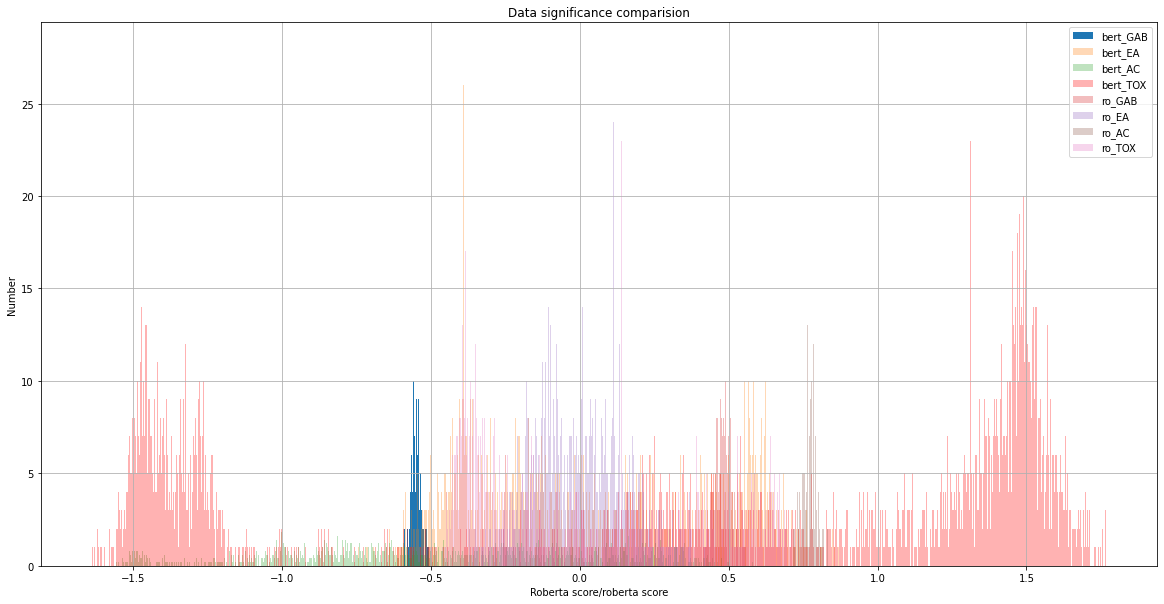

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
num_bins = 1000
n1, bins1, patches1 = plt.hist(bert_GAB_score,  label= 'bert_GAB', bins=num_bins)
n2, bins2, patches2 = plt.hist(bert_EA_score, label = 'bert_EA', bins = num_bins,alpha = 0.3)
n3, bins3, patches3 = plt.hist(bert_AC_score,label = 'bert_AC', bins = num_bins,alpha = 0.3,density = True)
n4, bins4, patches4 = plt.hist(bert_tox_score, label = 'bert_TOX', bins = num_bins,color='r', alpha = 0.3)
n5, bins5, patches5 = plt.hist(final_ro_GAB_score, label = 'ro_GAB', bins = num_bins,alpha = 0.3)
n6, bins6, patches6 = plt.hist(final_ro_EA_score, label = 'ro_EA', bins = num_bins,alpha = 0.3)
n7, bins7, patches7 = plt.hist(final_ro_AC_score, label = 'ro_AC', bins = num_bins,alpha = 0.3)
n8, bins8, patches8 = plt.hist(final_ro_tox_score, label = 'ro_TOX', bins = num_bins,alpha = 0.3)
plt.title('Data significance comparision')
plt.grid()
plt.ylabel('Number')
plt.xlabel('Roberta score/roberta score')
plt.legend()
plt.show()

In [57]:
y_prob_GAb_bert = [(bert_GAB_score[i] * (avg_2400/128)) for i in range(len(final_ro_tox_score))]
y_prob_EA_bert = [(bert_EA_score[i] * (avg_2400/128)) for i in range(len(final_ro_tox_score))]
y_prob_AC_bert = [(bert_AC_score[i] * (avg_2400/128)) for i in range(len(final_ro_tox_score))]
y_prob_TOX_bert = [(bert_tox_score[i] * (avg_2400/128)) for i in range(len(final_ro_tox_score))]
y_prob_GAb_Roberta = [(final_ro_GAB_score[i] * (avg_2400/128)) for i in range(len(final_ro_tox_score))]
y_prob_EA_Roberta = [(final_ro_EA_score[i] * (avg_2400/128)) for i in range(len(final_ro_tox_score))]
y_prob_AC_Roberta = [(final_ro_AC_score[i] * (avg_2400/128)) for i in range(len(final_ro_tox_score))]
y_prob_TOX_Roberta = [(final_ro_tox_score[i] * (avg_2400/128)) for i in range(len(final_ro_tox_score))]

In [59]:
mu1 =np.mean(y_prob_GAb_bert)
mu2 =np.mean(y_prob_EA_bert)
mu3 =np.mean(y_prob_AC_bert)
mu4 =np.mean(y_prob_TOX_bert)
mu5 =np.mean(y_prob_GAb_Roberta)
mu6 =np.mean(y_prob_EA_Roberta)
mu7 =np.mean(y_prob_AC_Roberta)
mu8 =np.mean(y_prob_TOX_Roberta)

sigma1 =np.std(y_prob_GAb_bert)
sigma2 =np.std(y_prob_EA_bert)
sigma3 =np.std(y_prob_AC_bert)
sigma4 =np.std(y_prob_TOX_bert)
sigma5 =np.std(y_prob_GAb_Roberta)
sigma6 =np.std(y_prob_EA_Roberta)
sigma7 =np.std(y_prob_AC_Roberta)
sigma8 =np.std(y_prob_TOX_Roberta)

In [60]:
print('Bert GAB_2400 mu:',mu1,'and sigma_2400:',sigma1)
print('Bert EA_2400 mu:',mu2,'and sigma_2400:',sigma2)
print('Bert AC_2400 mu:',mu3,'and sigma_2400:',sigma3)
print('Bert TOX_2400 mu:',mu4,'and sigma_2400:',sigma4)
print('RoBerta GAB_2400 mu:',mu5,'and sigma_2400:',sigma5)
print('RoBerta EA_2400 mu:',mu6,'and sigma_2400:',sigma6)
print('RoBerta AC_2400 mu:',mu7,'and sigma_2400:',sigma7)
print('RoBerta TOX_2400 mu:',mu8,'and sigma_2400:',sigma8)

Bert GAB_2400 mu: -0.117566070947268 and sigma_2400: 0.0038253748941490984
Bert EA_2400 mu: 0.007887538907728522 and sigma_2400: 0.08479906372310995
Bert AC_2400 mu: -0.09795903628551916 and sigma_2400: 0.10935770533442239
Bert TOX_2400 mu: 0.07664759451853975 and sigma_2400: 0.25045988561257704
RoBerta GAB_2400 mu: 0.10423087615657814 and sigma_2400: 0.00609735062067624
RoBerta EA_2400 mu: -0.002086608182302554 and sigma_2400: 0.031954514671760456
RoBerta AC_2400 mu: 0.16585392441174168 and sigma_2400: 0.005854642938097028
RoBerta TOX_2400 mu: 0.002096768848111415 and sigma_2400: 0.08079084950723224


In [73]:
from scipy.stats import norm
y1 = norm.pdf(bins1, mu1, sigma1)
y2 = norm.pdf(bins2, mu2, sigma2)
y3 = norm.pdf(bins3, mu3, sigma3)
y4 = norm.pdf(bins4, mu4, sigma4)
y5 = norm.pdf(bins5, mu5, sigma5)
y6 = norm.pdf(bins6, mu6, sigma6)
y7 = norm.pdf(bins7, mu7, sigma7)
y8 = norm.pdf(bins8, mu8, sigma8)

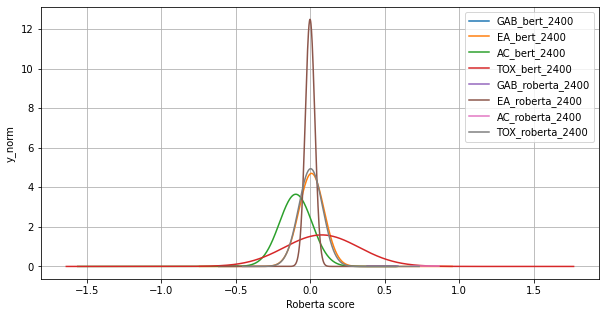

In [79]:
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(bins1, y1,label= 'GAB_bert_2400') 
plt.plot(bins2, y2,label= 'EA_bert_2400') 
plt.plot(bins3, y3,label= 'AC_bert_2400') 
plt.plot(bins4, y4,label= 'TOX_bert_2400')
plt.plot(bins5, y5,label= 'GAB_roberta_2400')
plt.plot(bins6, y6,label= 'EA_roberta_2400')
plt.plot(bins7, y7,label= 'AC_roberta_2400')
plt.plot(bins8, y8,label= 'TOX_roberta_2400')

plt.ylabel('y_norm')
# plt.xlim([-0.5,0.5])
plt.xlabel('Roberta score')
plt.legend()
plt.show()